In [63]:
import pandas as pd
import numpy as np
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [64]:
df = pd.read_csv('datasets/italian_real_estate_data.csv')

Select housing properties

In [65]:
# Count 'residential housing', 'independent houses and villas', 'typical local housing', 'lowcost housing'
df['type'].value_counts()

type
residential housing              1130314
independent houses and villas     816832
shops                             755641
garage                            749569
lowcost housing                   730813
warehouses                        634371
offices                           569504
laboratories                      538094
typical industrial buildings      410473
industrial buildings              247517
garages                           223490
uncovered parking spaces          160738
covered parking spaces            158096
shopping centers                   27626
structured offices                 20721
typical local housing              13631
luxury housing                      7883
guesthouses and similar             5142
sports facilities                     17
Name: count, dtype: int64

In [66]:
df_house = df.copy()

df_house = df_house[df_house['type'].isin(['residential housing', 'independent houses and villas', 'lowcost housing'])]

print('Rows before selecting housing properties:', len(df))
print('Rows after selecting housing properties:', len(df_house))

Rows before selecting housing properties: 7200472
Rows after selecting housing properties: 2677959


Missing values

In [67]:
# Check percentages of missing values
missing_values = (df_house.isnull().sum())
print("% of missing values in each column:\n", missing_values /len(df_house) * 100)

% of missing values in each column:
 listing_id    0.000000
year          0.000000
semester      0.000000
zone_link     0.000000
location      0.000000
region        0.000000
prov          2.036775
mun_istat     0.001307
mun_cat       0.000000
mun_cad       0.000000
mun_name      0.000000
sector        0.000000
zone          0.000000
type          0.000000
condition     0.002465
buy_min       0.024795
buy_max       0.024795
lease_min     9.703248
lease_max     9.703248
dtype: float64


In [68]:
#'lease_min' and 'lease_max'

# Total entries per region
region_counts = df_house['region'].value_counts()

# Missing lease_min per region
missing_lease_min = df_house[df_house['lease_min'].isnull()]['region'].value_counts()
percentage_min = missing_lease_min * 100 / region_counts

# Missing lease_max per region
missing_lease_max = df_house[df_house['lease_max'].isnull()]['region'].value_counts()
percentage_max = missing_lease_max * 100 / region_counts

# Missing lease_min + max per region
missing_lease_total = df_house[df_house['lease_min'].isnull() & df_house['lease_max'].isnull()]['region'].value_counts()
percentage_total = missing_lease_total * 100 / region_counts

df_missing_lease = pd.DataFrame({
    'pct_missing_min': percentage_min,
    'pct_missing_max': percentage_max,
    'pct_total': percentage_total
}).fillna(0) 

print(df_missing_lease)

                               pct_missing_min  pct_missing_max  pct_total
region                                                                    
ABRUZZO                               2.162627         2.162627   2.162627
BASILICATA                            0.400334         0.400334   0.400334
CALABRIA                              6.400140         6.400140   6.400140
CAMPANIA                              0.329865         0.329865   0.329865
EMILIA-ROMAGNA                       27.470795        27.470795  27.470795
FRIULI-VENEZIA GIULIA                 0.146545         0.146545   0.146545
LAZIO                                24.991975        24.991975  24.991975
LIGURIA                               0.060560         0.060560   0.060560
LOMBARDIA                             9.719569         9.719569   9.719569
MARCHE                                5.200385         5.200385   5.200385
MOLISE                               36.988974        36.988974  36.988974
PIEMONTE                 

In [69]:
df_house.groupby(['type'])['lease_min'].apply(lambda x: x.isnull().mean() * 100)
df_house.groupby(['type'])['lease_max'].apply(lambda x: x.isnull().mean() * 100)

type
independent houses and villas    14.056134
lowcost housing                   4.902212
residential housing               9.661740
Name: lease_max, dtype: float64

In [70]:
# Lease min and max values are structurally missing in some regions. Due to the high percentages of missing values 
# in the dataset, imputation is not possible. However, instead of dropping these columns, I will keep them in case a particular
# municipality has enough non-missing values for analysis/imputation. 

# !!!!!! As they are, 'lease_min' and 'lease_max' cannot be used !!!!!!

In [71]:
# 'condition'

# Missing condition per region
missing_condition = df_house[df_house['condition'].isnull()]['region'].value_counts()
percentage_condition = missing_condition * 100 / region_counts

df_missing_condition = pd.DataFrame({
    'pct_missing_condition': percentage_condition
}).fillna(0) 

print(df_missing_condition)

                               pct_missing_condition
region                                              
ABRUZZO                                     0.000000
BASILICATA                                  0.000000
CALABRIA                                    0.005342
CAMPANIA                                    0.004566
EMILIA-ROMAGNA                              0.002327
FRIULI-VENEZIA GIULIA                       0.009354
LAZIO                                       0.000000
LIGURIA                                     0.001009
LOMBARDIA                                   0.000000
MARCHE                                      0.001750
MOLISE                                      0.000000
PIEMONTE                                    0.002939
PUGLIA                                      0.000000
SARDEGNA                                    0.000000
SICILIA                                     0.007654
TOSCANA                                     0.007220
TRENTINO-ALTO ADIGE                         0.

In [72]:
# Missing 'condition' values can be imputed safely using the mode of 'region' + 'type'

In [73]:
df_house['condition'] = df_house.groupby(['region', 'type'])['condition'].transform(lambda x: x.fillna(x.mode()[0]))

print("Number of missing 'condition' values after imputation:", df_house['condition'].isnull().sum())

Number of missing 'condition' values after imputation: 0


In [74]:
#'buy_min' and 'buy_max'

# Missing buy_min per region
missing_buy_min = df_house[df_house['buy_min'].isnull()]['region'].value_counts()
percentage_buy_min = missing_buy_min * 100 / region_counts

# Missing buy_max per region
missing_buy_max = df_house[df_house['buy_max'].isnull()]['region'].value_counts()
percentage_buy_max = missing_buy_max * 100 / region_counts

# Missing buy_min + max per region
missing_buy_total = df_house[df_house['buy_min'].isnull() & df_house['buy_max'].isnull()]['region'].value_counts()
percentage_buy_total = missing_buy_total * 100 / region_counts

df_missing_buy = pd.DataFrame({
    'pct_missing_buy_min': percentage_buy_min,
    'pct_missing_buy_max': percentage_buy_max,
    'pct_buy_total': percentage_buy_total
}).fillna(0) 

print(df_missing_buy)

                               pct_missing_buy_min  pct_missing_buy_max  \
region                                                                    
ABRUZZO                                   0.000000             0.000000   
BASILICATA                                0.000000             0.000000   
CALABRIA                                  0.000000             0.000000   
CAMPANIA                                  0.000000             0.000000   
EMILIA-ROMAGNA                            0.364772             0.364772   
FRIULI-VENEZIA GIULIA                     0.000000             0.000000   
LAZIO                                     0.000000             0.000000   
LIGURIA                                   0.000000             0.000000   
LOMBARDIA                                 0.000885             0.000885   
MARCHE                                    0.000000             0.000000   
MOLISE                                    0.000000             0.000000   
PIEMONTE                 

In [75]:
# Missing 'buy_min' and 'buy_max' values are structural in specific regions (EMILIA-ROMAGNA, LOMBARDIA, VENETO). However,
# the low percentages of missing values justifies imputation. I will impute missing values using the median of 
# 'prov' + 'type' + 'condition' + 'year'.

In [76]:
cols = ['buy_min', 'buy_max']

for c in cols:
    df_house[c] = df_house.groupby(['region', 'type', 'condition', 'year'])[c].transform(lambda x: x.fillna(x.median()))
    print(f'Number of missing {c} values after imputation:', df_house[c].isnull().sum())

Number of missing buy_min values after imputation: 0
Number of missing buy_max values after imputation: 0


In [77]:
# Check for 'buy_min/max' == 0

#buy_min
zero_min = df_house[df_house['buy_min'] == 0]
print('Number of 0 values in buy_min:', len(zero_min))

#buy_max
zero_max = df_house[df_house['buy_max'] == 0]
print('Number of 0 values in buy_max:', len(zero_max))

Number of 0 values in buy_min: 9038
Number of 0 values in buy_max: 9038


In [78]:
# Distribution of 0 'buy_min/max' values across 'region'

# Total entries per region
region_counts = df_house['region'].value_counts()

# zero buy_min per region
zero_buy_min = df_house[df_house['buy_min'] == 0]['region'].value_counts()
percentage_zero_min = zero_buy_min * 100 / region_counts

# zero buy_max per region
zero_buy_max = df_house[df_house['buy_max'] == 0]['region'].value_counts()
percentage_zero_max = zero_buy_max * 100 / region_counts

# zero buy_min + max per region
zero_buy_total = df_house[(df_house['buy_min'] == 0) & (df_house['buy_max'] == 0)]['region'].value_counts()
percentage_zero_total = zero_buy_total * 100 / region_counts

df_missing_lease = pd.DataFrame({
    'pct_zero_min': percentage_zero_min,
    'pct_zero_max': percentage_zero_max,
    'pct_zero_total': percentage_zero_total
}).fillna(0) 

print(df_missing_lease)

                               pct_zero_min  pct_zero_max  pct_zero_total
region                                                                   
ABRUZZO                            2.125031      2.125031        2.125031
BASILICATA                         0.000000      0.000000        0.000000
CALABRIA                           0.000000      0.000000        0.000000
CAMPANIA                           0.000000      0.000000        0.000000
EMILIA-ROMAGNA                     0.176278      0.176278        0.176278
FRIULI-VENEZIA GIULIA              0.000000      0.000000        0.000000
LAZIO                              0.299310      0.299310        0.299310
LIGURIA                            0.000000      0.000000        0.000000
LOMBARDIA                          0.000000      0.000000        0.000000
MARCHE                             4.320091      4.320091        4.320091
MOLISE                             0.000000      0.000000        0.000000
PIEMONTE                           0.0

In [79]:
# Dropping rows with 0 'buy_min/max' values
df_house = df_house[(df_house['buy_min'] != 0) & (df_house['buy_max'] != 0)]

In [80]:
# Create log-transformed columns for 'buy_min/max'
for c in cols:
    df_house[f'log_{c}'] = np.log(df_house[c])

In [81]:
# Create 'buy_avg/range', 'log_buy_avg/range', and 'geom_buy_avg/range' columns
df_house['buy_avg'] = (df_house['buy_min'] + df_house['buy_max']) / 2
df_house['buy_range'] = df_house['buy_max'] - df_house['buy_min']

df_house['log_buy_avg'] = (df_house['log_buy_min'] + df_house['log_buy_max']) / 2
df_house['log_buy_range'] = df_house['log_buy_max'] - df_house['log_buy_min']

df_house['geom_buy_avg'] = df_house['log_buy_avg'].apply(np.exp)
df_house['geom_buy_range'] = df_house['log_buy_range'].apply(np.exp)

In [82]:
# Analysis of variability of 'buy_min/max', 'log_buy_min/max', 'buy_avg/range', 'log_buy_avg/range', 
# 'geom_buy_avg/range'

cols = ['buy_min', 'buy_max', 'log_buy_min', 'log_buy_max', 'buy_avg','log_buy_avg', 'geom_buy_avg', 
        'buy_range', 'log_buy_range', 'geom_buy_range']

def variability(data, cols):

    results = []

    for c in cols:
        mean = data[c].mean()
        median = data[c].median()
        range = data[c].max() - data[c].min()
        std = data[c].std()
        coeff_var = std / mean

        results.append({
            'column': c,
            'avg': mean,
            'median': median,
            'range': range,
            'std': std,
            'coeff_var': coeff_var,
        })

    return pd.DataFrame(results)
    
variability(df_house, cols)   

,column,avg,median,range,std,coeff_var
0,buy_min,1030.152950,860.000000,14672.000000,667.429081,0.647893
1,buy_max,1366.397269,1150.000000,20962.000000,901.215313,0.659556
2,log_buy_min,6.781705,6.756932,6.263398,0.544122,0.080234
3,log_buy_max,7.066815,7.047517,6.314692,0.534412,0.075623
4,buy_avg,1198.275110,1000.000000,17317.000000,781.015624,0.651783
5,log_buy_avg,6.924260,6.902225,6.256281,0.537131,0.077572
6,geom_buy_avg,1184.998052,994.484791,16970.910033,771.053367,0.650679
7,buy_range,336.244319,270.000000,8800.000000,274.517066,0.816421
8,log_buy_range,0.285110,0.292388,2.639057,0.096391,0.338083
9,geom_buy_range,1.336055,1.339623,13.000000,0.127843,0.095687


Viasualise variables

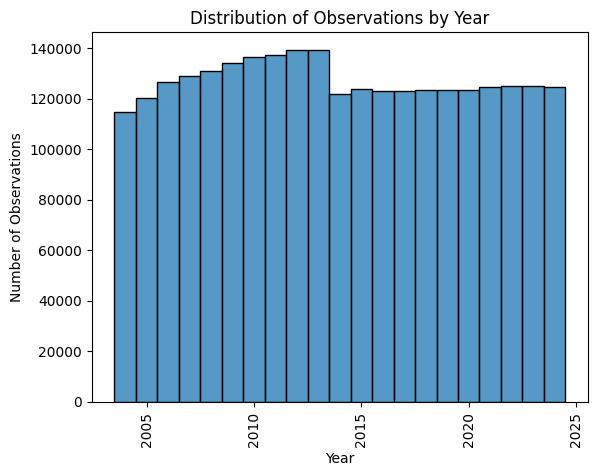

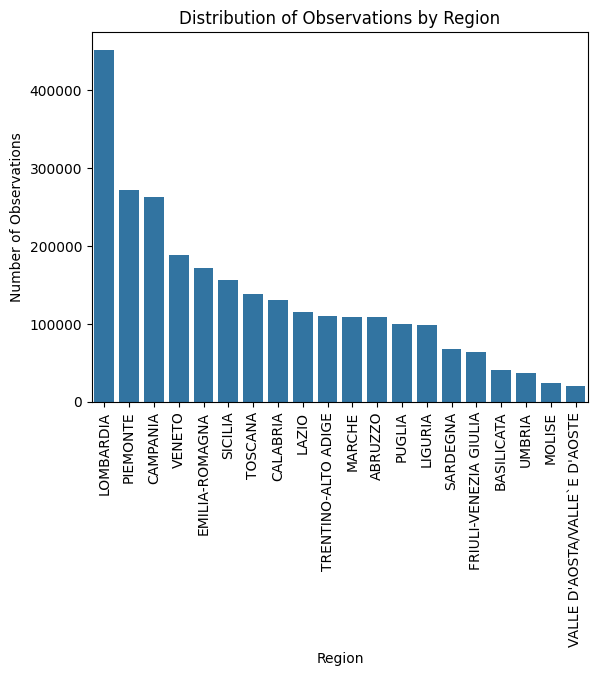

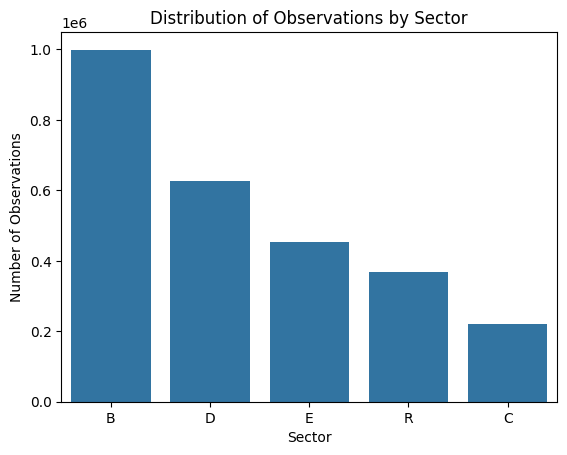

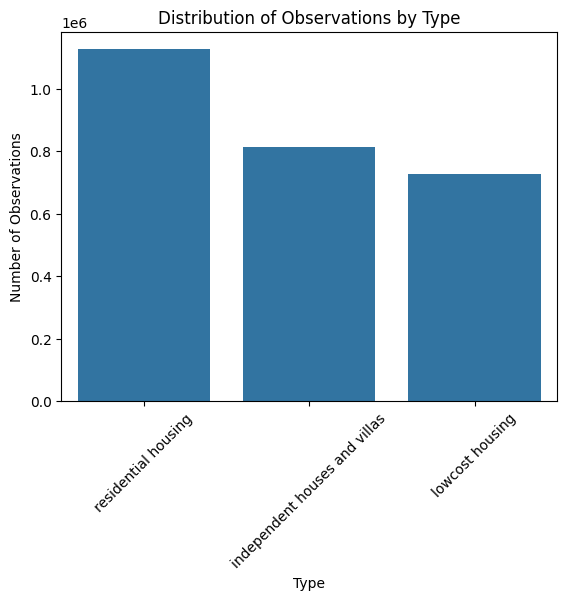

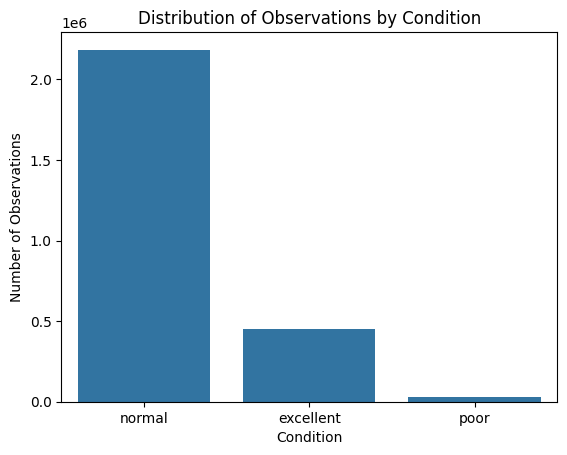

In [83]:
# Distribution of observations over year
sns.histplot(data=df_house, x='year', discrete=True)
plt.title('Distribution of Observations by Year')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.xticks(rotation=90)
plt.show()

# Region distribution
sns.countplot(data=df_house, x='region', order=df_house['region'].value_counts().index)
plt.title('Distribution of Observations by Region')
plt.xlabel('Region')
plt.ylabel('Number of Observations')
plt.xticks(rotation=90)
plt.show()

# Sector distribution
sns.countplot(data=df_house, x='sector', order=df_house['sector'].value_counts().index)
plt.title('Distribution of Observations by Sector')
plt.xlabel('Sector')
plt.ylabel('Number of Observations')
plt.show()

# Type distribution
sns.countplot(data=df_house, x='type', order=df_house['type'].value_counts().index)
plt.title('Distribution of Observations by Type')
plt.xlabel('Type')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.show()

# Condition dsitribution
sns.countplot(data=df_house, x='condition', order=df_house['condition'].value_counts().index)
plt.title('Distribution of Observations by Condition')
plt.xlabel('Condition')
plt.ylabel('Number of Observations')
plt.show()

Checking for possible biases in buy_avg distribution, considering the drop of observations between 2013_S2 and 2014_S1

In [84]:
# Restoring year_semester column
df_house['year_semester'] = df_house['year'].astype(str) + '_' + df_house['semester'].astype(str)

df_house.insert(3, 'year_semester', df_house.pop('year_semester'))

df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2668921 entries, 0 to 7200465
Data columns (total 28 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      uint64 
 1   year            int64  
 2   semester        int64  
 3   year_semester   object 
 4   zone_link       object 
 5   location        object 
 6   region          object 
 7   prov            object 
 8   mun_istat       float64
 9   mun_cat         object 
 10  mun_cad         object 
 11  mun_name        object 
 12  sector          object 
 13  zone            object 
 14  type            object 
 15  condition       object 
 16  buy_min         float64
 17  buy_max         float64
 18  lease_min       float64
 19  lease_max       float64
 20  log_buy_min     float64
 21  log_buy_max     float64
 22  buy_avg         float64
 23  buy_range       float64
 24  log_buy_avg     float64
 25  log_buy_range   float64
 26  geom_buy_avg    float64
 27  geom_buy_range  float64
dtypes: float64(13), i

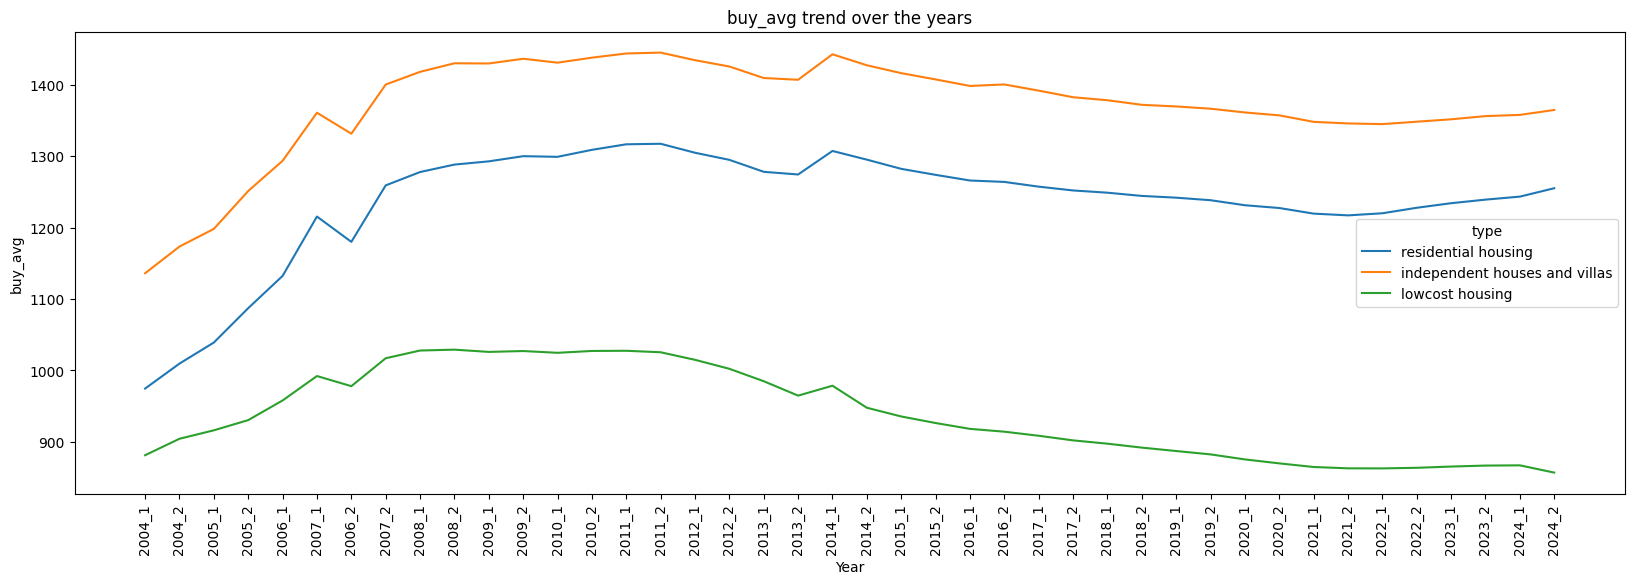

In [85]:
# Plot buy_avg trend
plt.figure(figsize=(20,6))
sns.lineplot(data = df_house, x='year_semester', y = 'buy_avg', hue='type', errorbar=None)
plt.title('buy_avg trend over the years')
plt.xlabel('Year')
plt.ylabel('buy_avg')
plt.xticks(rotation=90)
plt.show()

In [86]:
# Due to the drop of observation between 2013_2 and 2014_1 drops are evident in prices trends. However, due to different 
# effects of this drop on prices distribution over different features, prices trends will be analyzed differently between
# 2004 and 2013_2, and between 2014_1 and 2024. 

In [87]:
# Create dataset for post 2014 analysis
df_post_2014 = df_house[df_house['year'] >= 2014].copy()

df_post_2014.head()

,listing_id,year,semester,year_semester,zone_link,location,region,prov,mun_istat,mun_cat,...,lease_min,lease_max,log_buy_min,log_buy_max,buy_avg,buy_range,log_buy_avg,log_buy_range,geom_buy_avg,geom_buy_range
3653725,4685219462078301784,2014,1,2014_1,AL00000001,NW,PIEMONTE,AL,1006003.0,A2AA,...,3.4,5.0,6.522093,6.866933,820.0,280.0,6.694513,0.344840,807.960395,1.411765
3653733,17875868790139417378,2014,1,2014_1,AL00000003,NW,PIEMONTE,AL,1006003.0,A2AA,...,3.8,5.6,6.507278,6.877296,820.0,300.0,6.692287,0.370018,806.163755,1.447761
3653737,14994624084586742221,2014,1,2014_1,AL00000003,NW,PIEMONTE,AL,1006003.0,A2AA,...,3.3,4.5,6.684612,7.090077,1000.0,400.0,6.887344,0.405465,979.795897,1.500000
3653744,18254477012295926414,2014,1,2014_1,AL00004457,NW,PIEMONTE,AL,1006003.0,A2AA,...,3.3,4.6,6.606650,6.907755,870.0,260.0,6.757203,0.301105,860.232527,1.351351
3653751,5157533477511469553,2014,1,2014_1,AL00004458,NW,PIEMONTE,AL,1006003.0,A2AA,...,3.1,4.4,6.551080,6.956545,875.0,350.0,6.753813,0.405465,857.321410,1.500000


In [88]:
# Save df_post_2014 as 'house_post_2014_data.csv'
df_post_2014.to_csv('datasets/house_post_2014_data.csv', index=False)

In [89]:
# Update 'house_data' with a dummy variable for pre 2014 (0) and post 2014 (1). 
df_house['post_2014'] = np.where(df_house['year'] >= 2014, 1, 0)

df_house.insert(4, 'post_2014', df_house.pop('post_2014'))

df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2668921 entries, 0 to 7200465
Data columns (total 29 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      uint64 
 1   year            int64  
 2   semester        int64  
 3   year_semester   object 
 4   post_2014       int64  
 5   zone_link       object 
 6   location        object 
 7   region          object 
 8   prov            object 
 9   mun_istat       float64
 10  mun_cat         object 
 11  mun_cad         object 
 12  mun_name        object 
 13  sector          object 
 14  zone            object 
 15  type            object 
 16  condition       object 
 17  buy_min         float64
 18  buy_max         float64
 19  lease_min       float64
 20  lease_max       float64
 21  log_buy_min     float64
 22  log_buy_max     float64
 23  buy_avg         float64
 24  buy_range       float64
 25  log_buy_avg     float64
 26  log_buy_range   float64
 27  geom_buy_avg    float64
 28  geom_buy_range  f

In [90]:
# Update 'house_data.csv'
df_house.to_csv('datasets/house_data.csv', index=False)